# Modelling

### import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import os
import itertools
from collections import Counter
import re
import string

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
import contractions
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

from joblib import dump, load

### import cleaned data

import the cleaned data csv created from data_cleaning.ipynb

In [3]:
df_tweets=pd.read_csv('train_cleaned.csv')

In [4]:
df_tweets.head()

,id,text,target,text_length,nos_uppercase,nos_punc,nos_words,perc_uppercase,perc_punc,hashtags,nos_hashtags,perc_hashtags,clean_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,69,10,1,13,0.144928,0.014493,earthquake,1,0.076923,deed reason may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,38,5,1,7,0.131579,0.026316,NaN,0,0.000000,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,133,2,3,22,0.015038,0.022556,NaN,0,0.000000,resident asked 'shelter place notified officer...
3,6,"13,000 people receive #wildfires evacuation or...",1,65,1,2,8,0.015385,0.030769,wildfires,1,0.125000,people receive evacuation order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88,3,2,16,0.034091,0.022727,alaska wildfires,2,0.125000,got sent photo ruby smoke pours school


In [5]:
df_tweets.describe()

,id,target,text_length,nos_uppercase,nos_punc,nos_words,perc_uppercase,perc_punc,nos_hashtags,perc_hashtags
count,7613.000000,7613.00000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,5441.934848,0.42966,101.037436,9.923158,6.839485,15.734270,0.099661,0.068092,0.437410,0.028682
std,3137.116090,0.49506,33.781325,10.436544,4.608758,5.904715,0.107443,0.043268,1.085629,0.071075
min,1.000000,0.00000,7.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2734.000000,0.00000,78.000000,3.000000,3.000000,11.000000,0.038462,0.037037,0.000000,0.000000
50%,5408.000000,0.00000,107.000000,7.000000,6.000000,16.000000,0.074627,0.066176,0.000000,0.000000
75%,8146.000000,1.00000,133.000000,13.000000,10.000000,20.000000,0.125926,0.090909,0.000000,0.000000
max,10873.000000,1.00000,157.000000,118.000000,61.000000,32.000000,1.000000,0.500000,13.000000,0.750000


In [6]:
df_tweets.isnull().sum()

id                   0
text                 0
target               0
text_length          0
nos_uppercase        0
nos_punc             0
nos_words            0
perc_uppercase       0
perc_punc            0
hashtags          5870
nos_hashtags         0
perc_hashtags        0
clean_text           6
dtype: int64

null in hashtags is because there is no hashtags <br>
null in clean_text is because all words in orginal text are removed <br>

In [7]:
#get all the feature columns
all_cols=list(df_tweets.columns)

In [8]:
all_cols.remove('target')

In [9]:
#categorize the features into numeric colummns and text columns by their data type
numeric_cols=[]
text_cols=[]
for col in all_cols:
    data_type=df_tweets[col].dtype
    if data_type=='O':
        text_cols.append(col)
    else:
        numeric_cols.append(col)

In [10]:
#remove id and original text columns
if 'id' in numeric_cols:
    numeric_cols.remove('id')
if 'text' in text_cols:
    text_cols.remove('text')

In [11]:
#remove number of uppercase, punctuation and hashtags columns
#they are used to create the respective percentage columns
for col in ['nos_uppercase','nos_punc','nos_hashtags']:
    numeric_cols.remove(col)

In [12]:
print(numeric_cols,text_cols)

['text_length', 'nos_words', 'perc_uppercase', 'perc_punc', 'perc_hashtags'] ['hashtags', 'clean_text']


In [13]:
#fill the nulls in cleaned text and hashtags by " " for applying vectorizer
for col in text_cols:
    df_tweets[col].fillna(" ",inplace=True)

### train test split

In [14]:
#train test split, 20% as test
X=df_tweets[numeric_cols+text_cols]
y=df_tweets['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature engineering

The following feature engineering will be done: <br>
tfidf vectorizer on cleaned text <br>
tfidf vectorizer on hastags <br>
min max scaler on length of text and no of word tokens <br>

#### Countvectorize

In [15]:
X_train.head()

,text_length,nos_words,perc_uppercase,perc_punc,perc_hashtags,hashtags,clean_text
4996,140,19,0.064286,0.057143,0.052632,hiroshima70,courageous honest analysis need use atomic bom...
3263,98,15,0.051020,0.040816,0.066667,boycottbears,wld b shame golf cart became engulfed flame
4907,143,23,0.132867,0.083916,0.000000,,tell rescind medal 'honor given u soldier mass...
2855,118,18,0.101695,0.067797,0.000000,,worried ca drought might affect extreme weathe...
4716,82,9,0.146341,0.073171,0.111111,pantherattack,lava blast power red alifaditha


In [16]:
#a function to train words countvectorizer
def train_vectorizer(df,col,max_features=1000,scaled=True):
    if scaled:
        vectorizer = TfidfVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 max_features = max_features)
    else:
        vectorizer = CountVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 max_features = max_features)
    features = vectorizer.fit_transform(df[col])
    features = features.toarray()
    df_features=pd.DataFrame(data=features,columns=vectorizer.get_feature_names_out(),index=df.index)
    return vectorizer,df_features

In [17]:
#a function to apply word countvectorizer
def apply_vectorizer(df,col,vectorizer):
    features = vectorizer.transform(df[col])
    features = features.toarray()
    df_features=pd.DataFrame(data=features,columns=vectorizer.get_feature_names_out(),index=df.index)
    return df_features

In [18]:
#train the word vectorizer
text_vectorizer,X_train_text=train_vectorizer(X_train,'clean_text',max_features=2500)
hashtags_vectorizer,X_train_hashtags=train_vectorizer(X_train,'hashtags',max_features=500)

In [19]:
#apply the word vectorizer
X_test_text=apply_vectorizer(X_test,'clean_text',text_vectorizer)
X_test_hashtags=apply_vectorizer(X_test,'hashtags',hashtags_vectorizer)

In [20]:
#train data of cleaned text after apply vectorizer
X_train_text.head()

,aa,aba,abandoned,abbswinston,abc,ability,ablaze,able,absolutely,abuse,...,yo,yobe,york,you,young,youth,youtube,yr,zombie,zone
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#train data of hashtags after apply vectorizer
X_train_hashtags.head()

,039,360wisenews,5sosfam,abstorm,accident,afc,africa,afterlife,airplane,alaska,...,wx,yazidis,yes,yonews,youtube,yugvani,yyc,yycstorm,zionism,zionist
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#join the data of numeric columns with the data of cleaned text and data of hashtags after apply vectorizer
X_train_join=X_train[numeric_cols]\
.join(X_train_text)\
.join(X_train_hashtags,lsuffix='t',rsuffix='h')

X_test_join=X_test[numeric_cols]\
.join(X_test_text)\
.join(X_test_hashtags,lsuffix='t',rsuffix='h')

#### Scaling

In [23]:
#apply scaling to numeric columns that is not percentage
scaler_cols=[col for col in numeric_cols if not re.match(r"perc\w*",col)]

In [24]:
#apply scaling to length of text and no of word tokens
scaler_cols

['text_length', 'nos_words']

In [25]:
#use min max scaler
scaler=MinMaxScaler()

In [26]:
#train the min max scaler
scaled_features=scaler.fit_transform(X_train[scaler_cols])
scaled_features=pd.DataFrame(data=scaled_features,columns=scaler.feature_names_in_,index=X_train.index)
for col in scaled_features:
    X_train_join[col]=scaled_features[col]

In [27]:
#apply the min max scaler
scaled_features=scaler.transform(X_test[scaler_cols])
scaled_features=pd.DataFrame(data=scaled_features,columns=scaler.feature_names_in_,index=X_test.index)
for col in scaled_features:
    X_test_join[col]=scaled_features[col]

In [28]:
#the joined train data after apply min max scaler
X_train_join.head()

,text_length,nos_words,perc_uppercase,perc_punc,perc_hashtags,aa,aba,abandoned,abbswinston,abc,...,wx,yazidis,yesh,yonews,youtubeh,yugvani,yyc,yycstorm,zionism,zionist
4996,0.886667,0.580645,0.064286,0.057143,0.052632,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3263,0.606667,0.451613,0.051020,0.040816,0.066667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4907,0.906667,0.709677,0.132867,0.083916,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2855,0.740000,0.548387,0.101695,0.067797,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4716,0.500000,0.258065,0.146341,0.073171,0.111111,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### modelling

2 parts of modelling: <br>
1. apply individual models (logistic regression, SVC and random forest) <br>
2. apply ensemble learning (soft voting classifier) to combine the individual models <br>

metrics: accuracy score and F1 score

In [29]:
#apply logistic regression
model=LogisticRegression()
model.fit(X_train_join,y_train)
y_pred_proba=model.predict_proba(X_test_join)[:,1]
cut_off=0.5
y_pred=np.where(y_pred_proba>cut_off,1,0)
score=metrics.accuracy_score(y_test,y_pred)
f1=metrics.f1_score(y_test,y_pred)

In [30]:
#result of logistic regression
print(score,f1)

0.8069599474720945 0.7570247933884298


In [31]:
metrics.roc_auc_score(y_true=y_test,y_score=y_pred_proba)

0.8589768452080828

In [32]:
#apply logistic regression, SVC and random forest
models=[LogisticRegression(),SVC(),RandomForestClassifier()]
scores=[]
f1s=[]
for model in models:
    model.fit(X_train_join,y_train)
    y_pred=model.predict(X_test_join)
    #look at the metrics
    score=metrics.accuracy_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    scores.append(score)
    f1s.append(f1)
    print(score,f1)

0.8069599474720945 0.7570247933884298
0.8056467498358503 0.7508417508417509
0.7898883782009193 0.7163120567375887


In [33]:
#put the metrics of indiviual models into a dataframe
df_models_results=pd.DataFrame()
df_models_results['score']=scores
df_models_results['F1_score']=f1s

In [36]:
df_models_results.index=['Logistic_reg','SVC','random_forest']

In [37]:
df_models_results

,score,F1_score
Logistic_reg,0.806960,0.757025
SVC,0.805647,0.750842
random_forest,0.789888,0.716312


In [38]:
#apply ensemble learning (soft voting classifier)
models=[LogisticRegression(),SVC(probability=True),RandomForestClassifier()]
estimators=[(str(i),model) for i,model in enumerate(models)]
ensemble_clf=VotingClassifier(estimators=estimators,voting='soft')
ensemble_clf.fit(X_train_join,y_train)
y_pred=ensemble_clf.predict(X_test_join)
y_pred_proba=ensemble_clf.predict_proba(X_test_join)[:,1]
#look at the metrics
score=metrics.accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
print(score,f1)

0.8128693368351937 0.7611064543168484


In [39]:
ra_score=metrics.roc_auc_score(y_true=y_test,y_score=y_pred_proba)
ra_score

0.864724113492682

In [40]:
df_ensem_result=pd.DataFrame()
df_ensem_result['score']=[score]
df_ensem_result['F1_score']=[f1]
df_ensem_result['roc_auc_score']=[ra_score]
df_ensem_result.index=['Ensemble_learning']
df_ensem_result

,score,F1_score,roc_auc_score
Ensemble_learning,0.812869,0.761106,0.864724


In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

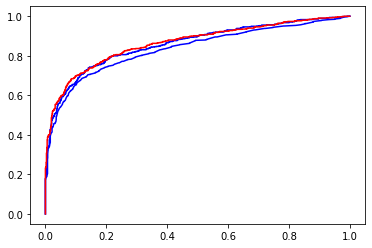

In [44]:
models=[LogisticRegression(),RandomForestClassifier()]
scores=[]
f1s=[]
ra_scores=[]
for model in models:
    model.fit(X_train_join,y_train)
    y_pred=model.predict(X_test_join)
    y_pred_proba=model.predict_proba(X_test_join)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
    plt.plot(fpr,tpr,color='blue')
    score=metrics.accuracy_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    ra_score=metrics.roc_auc_score(y_true=y_test,y_score=y_pred_proba)
    scores.append(score)
    f1s.append(f1)
    ra_scores.append(ra_score)
y_pred_proba=ensemble_clf.predict_proba(X_test_join)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr,tpr,color='red')

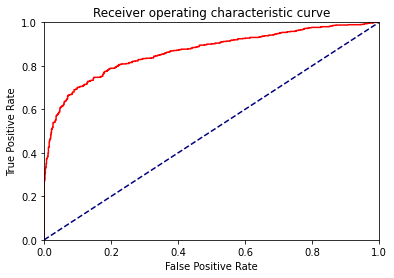

In [242]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr,tpr,color='red')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve")
# plt.legend(loc="lower right")
plt.show()

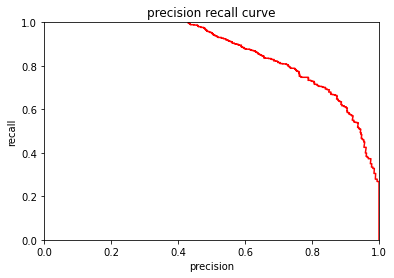

In [243]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred_proba)
plt.plot(precision,recall,color='red')
# plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("precision recall curve")
# plt.legend(loc="lower right")
plt.show()

In [224]:
len(ensemble_clf.feature_names_in_)

3005

## Save model

save the followings using joblib: <br>
cleaned_text vectorizer <br>
hashtags vectorizer <br>
min-max scaler <br>
ensemble learning classifier <br>

In [245]:
model_dicts={'text_vec':text_vectorizer,'hashtags_vec':hashtags_vectorizer,
            'scaler':scaler,'clf':ensemble_clf
            }

In [246]:
for name,model in model_dicts.items():
    dump(model, f'{name}.joblib') 